## K-Means Cluster Analysis of Fidelity Fund Returns 
### University of Virginia
### DS 7200: Distributed Computing
### Last Updated: August 20, 2023

---

### Justin Lee

### jgh2xh

---

## Instructions

In this assignment, you will conduct a k-means cluster analysis on a set of Fidelity mutual funds.  
This helps to group similar funds based on their performance (as opposed to their description, which is typical).  
The outline below will walk you through the required steps.  

This assignment is worth a total of **10 POINTS.**

## Data Details 

The file *fido_returns_funds_on_rows.csv* is the processed data for k-means. Additional details about this file: 
- Each row represents a mutual fund  
- Each column represents a trading day (these are used as features)  
- Each value represents the daily percentage change in price between the current trading day and previous trading day

### Load Modules and Read Data into Spark DataFrame

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

DATA_FILEPATH = 'fido_returns_funds_on_rows.csv'

spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/10 01:43:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv(DATA_FILEPATH, inferSchema=True, header=True)

In [3]:
print('df shape:', (df.count(), len(df.columns)))

df shape: (927, 1731)


**(VALUE: 2 POINTS) Assemble the Features into a column. 
Show the first five rows of data ONLY for the features column.
(this should make things easier to read)**

In [4]:
from pyspark.ml.feature import VectorAssembler

feats = df.columns
va = VectorAssembler(inputCols=feats, outputCol='features')
df = va.transform(df)

df.select('features').show(5)

23/10/10 01:43:41 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+
|            features|
+--------------------+
|[0.0,0.0,-0.01040...|
|[0.0,0.0,-0.01051...|
|[0.0,0.0,-0.01076...|
|[0.0,8.26105E-4,-...|
|[0.0,8.2815740000...|
+--------------------+
only showing top 5 rows



**(VALUE: 1 POINT) Set up the k-means model and train the model**  
Use parameters: 
- 3 clusters
- maximum of 10 iterations 
- seed=314

In [5]:
from pyspark.ml.clustering import KMeans

k = 3
maxiter = 10
seed = 314

kmeans = KMeans() \
         .setK(k) \
         .setSeed(seed) \
         .setMaxIter(maxiter)

model = kmeans.fit(df)

23/10/10 01:44:01 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


In [6]:
preds = model.transform(df)
preds.select('prediction').show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         2|
|         2|
|         2|
|         2|
|         1|
|         1|
|         1|
|         1|
|         2|
|         0|
|         0|
|         2|
|         0|
|         0|
|         2|
|         0|
|         2|
+----------+
only showing top 20 rows



**(VALUE: 2 POINTS) Compute and Print the Silhouette Score**  

In [7]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(preds)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.4227167920104707


**(VALUE: 2 POINTS) Define a function `kmeans_range()` that does the following:**
- takes an integer representing the lower bound for k
- takes an integer representing the upper bound for k
- take a Spark DataFrame containing training data
- fit K-means with k ranging from lower bound to upper bound, inclusive  
- the other parameters should be the same as earlier 
- for each k, compute the silhouette score
- return a pandas dataframe with columns containing k, silhouette score (each row holds the score for given k)

In [8]:
import pandas as pd

def kmeans_range(df, lower, upper):
    # hyperparams
    maxiter = 10
    seed = 314
    
    # evaluator
    evaluator = ClusteringEvaluator()
    
    # results
    results_dict = {}
    ks = []
    silhouettes = []
    
    # do k means from lower to upper (inclusive)
    for k in range(lower, upper + 1):
        kmeans = KMeans().setK(k).setSeed(seed).setMaxIter(maxiter)
        model = kmeans.fit(df)
        preds = model.transform(df)
        silhouette = evaluator.evaluate(preds)
        
        ks.append(k)
        silhouettes.append(silhouette)
    
    # to pd dataframe
    results_dict['k'] = ks
    results_dict['silhouette score'] = silhouettes
    pd_df = pd.DataFrame.from_dict(results_dict)
    
    return pd_df

**(VALUE: 1 POINT) Call `kmeans_range` to compute K-means with clusters ranging from 2 to 10 inclusive, printing the resulting dataframe.**

In [9]:
pd_df = kmeans_range(df, 2, 10)

23/10/10 01:44:31 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB


23/10/10 01:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


23/10/10 01:44:42 WARN DAGScheduler: Broadcasting large task binary with size 1042.5 KiB


23/10/10 01:44:48 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


23/10/10 01:44:53 WARN DAGScheduler: Broadcasting large task binary with size 1069.5 KiB


23/10/10 01:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1083.1 KiB


23/10/10 01:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


23/10/10 01:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB


23/10/10 01:45:13 WARN DAGScheduler: Broadcasting large task binary with size 1123.7 KiB


In [10]:
pd_df

,k,silhouette score
0,2,0.602396
1,3,0.422717
2,4,0.500796
3,5,0.459791
4,6,0.445675
5,7,0.382670
6,8,0.410208
7,9,0.513384
8,10,0.455571


**(VALUE: 1 POINT) Produce a plot with cluster numbers k on the x-axis, sihouette scores on the y-axis**

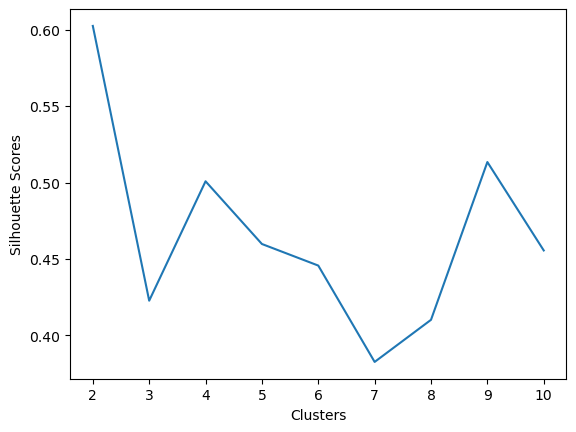

In [11]:
import matplotlib.pyplot as plt

plt.plot(pd_df['k'], pd_df['silhouette score'])
plt.xlabel('Clusters')
plt.ylabel('Silhouette Scores')
plt.show()
plt.close()

**(VALUE: 1 POINT) Based on how the silhouette score is calculated, what is its time complexity? (e.g., O(log n))**  
You can find the definition of the silhouette score in the lecture notes, for example. 

Silhouette Score:

For each $x \in X$ :
 * Let $C$ be the cluster that contains $x$
 * $A_x \gets \frac{1}{N_C} \sum_{x^\prime \in C \setminus \{x\}} d(x, x^\prime)$ where $N_C$ is the number of elements in $C$
 * $B_x \gets \min_{C^\prime} \frac{1}{N_{C^\prime}} \sum_{x^\prime \in C^\prime} d(x, x^\prime)$ for $C^\prime \neq C$ where $N_{C^\prime}$ is the number of elements in $C^\prime$
 * $s_x \gets \frac{B_x - A_x}{\max (A_x, B_x)}$

$s \gets \frac{1}{N} \sum_{x \in X} s_x$ where $N$ is the total number of points

------

For a single iteration, calculating $A_x$ requires computing the Euclidian distance between $x$ and every other point in $C$. Calculating $B_x$ requires computing the Euclidian distance between $x$ and every other point not in $C$. In other words, we need to calculate the Eucilidian distance between $x$ and every other point in the dataset. Calculating $s_x$ is done in constant time $\mathcal{O}(1)$. Therefore, the running time for each iteration is $\mathcal{O}(N)$. There are $N$ iterations, so the for-loop costs $\mathcal{O}(N^2)$ time. The final step is to compute $s$, and this is a sum over $N$ values, so it costs $\mathcal{O}(N)$. The linear term $N$ gets subsumed by the quadratic term $N^2$, so the time complexity is $\mathcal{O}(N^2)$.